Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import cv2
import os

Define path

In [2]:
dataset_path = '/home/ravisane/Downloads/MTP/ptbdb/'
data = open('/home/ravisane/Downloads/MTP/ptbdb/RECORDS.txt', 'r')

Define init values

In [3]:
num_samples = 10000     # no of samples to read from each  record
records = 549          # total records
num_leads = 12         # 12 leads out of given 15 to be choosen
sampling_freq = 1000   # 1000 Hz
images_required = 250 
each_lead_time = 2.5   # 2.5 seconds
mov_avg_filt = 25      # mov avg filter
display_factor = 1.5  # to scale the image
line_width = 1.5
images_per_record = 10

Storing the resultant into signals and fields.

In [4]:
# input the data from the ptb dataset
from read_ptb_data import read_data

signals, fields = read_data(data=data, dataset_path=dataset_path, 
                            M=mov_avg_filt, each_lead_time=each_lead_time,
                            num_samples=num_samples, num_leads=num_leads, 
                            images_per_record=images_per_record)# call fn to read PTB db
sampling_freq = fields[0]['fs']

Dataset Read!!!


In [5]:
# to create ecg records from ptb db
from create_images import create

create(signals, fields, 
       images_required=images_required, path='./', 
       display_factor=display_factor, 
       sampling_freq=sampling_freq, 
       line_color = (0,0,0),
        line_width=1.5) # call fn to create ECG graphs

ECG Graph Created


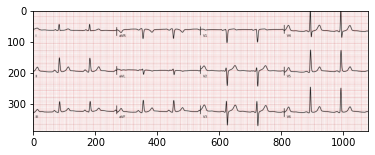

In [6]:
plt.imshow(mpimg.imread('./ptbdb/Healthy control/HC_ecg_1.jpg'))

In [4]:
# to read created ecg images
from read_images import read_img

# Resize all pics
w = 1800
h = 600
c = 3
path = './ptbdb/'

In [5]:
data, label = read_img(path=path, w=w, h=h, c=c) # call the function to read the data

ECG Images Read!!!


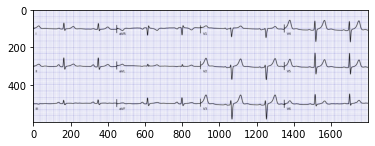

In [6]:
# after resizing and processing
plt.imshow(data[0])

In [7]:
# to convert read images to plots ie having 1D data
from image_to_plot import get_12_ecgs, graph_to_plot, moving_avg_filt

# parameters
image_intensity_threshold = 125
crop_pixels_out = 2
moving_avg_value = 3

In [8]:
# call above three functions
data_recovered = []
for i in range(len(data)):
    ecg_images_extracted = get_12_ecgs(data[i], 
                                       thresh=image_intensity_threshold, 
                                       crop=crop_pixels_out)
    
    raw_data = graph_to_plot(ecg_images_extracted)
    
    data_recovered += [moving_avg_filt(raw_data, M=moving_avg_value)]
    
data_recovered = np.array(data_recovered)
print("ECG images converted to plot data...Done")

ECG images converted to plot data...Done


### Binary Image of one ECG Lead

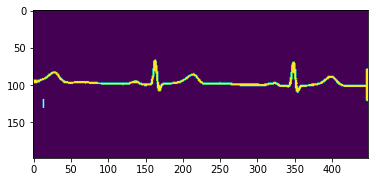

In [12]:
ecg_images_extracted = get_12_ecgs(data[0], 
                                   thresh=image_intensity_threshold, 
                                   crop=crop_pixels_out)
plt.imshow(ecg_images_extracted[0])
plt.savefig(path+'/ecg.jpg')

### Raw ECG Plot

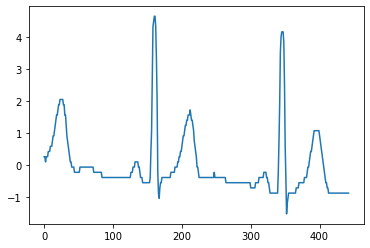

In [13]:
raw_data = graph_to_plot(ecg_images_extracted)
plt.plot(range(len(raw_data[0])), raw_data[0])
plt.savefig(path+'/raw_ecg.jpg')

### Filtered ECG Plot

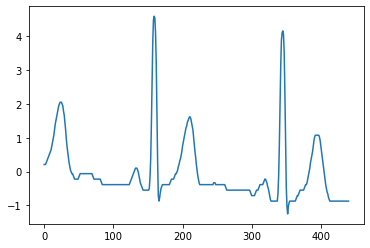

In [14]:
tempz = moving_avg_filt(raw_data, M=moving_avg_value)
plt.plot(range(len(tempz[0])), tempz[0])
plt.savefig(path+'/filtered_ecg.jpg')

In [17]:
del(data) # to free up memory
# save recovered data & labels in files

new_path = './data_folder'
if not os.path.exists(new_path):
    os.makedirs(new_path)

np.save(new_path+'/'+'data', data_recovered)
np.save(new_path+'/'+'label', label)

In [18]:
# load the saved data
new_path = './data_folder'
data_recovered = np.load(new_path+'/'+'data.npy')
label = np.load(new_path+'/'+'label.npy')

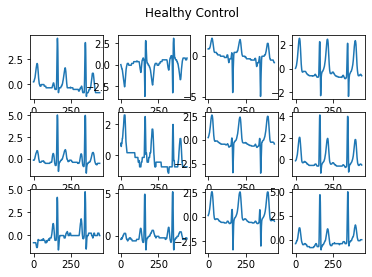

In [19]:
# Plot graph of recovered signals of jth record
j = 0
plt.figure()
if label[j]:
    plt.suptitle("Myocardial infarction")
else:
    plt.suptitle("Healthy Control")
for leads in range(num_leads):         
    plt.subplot(3, 4, leads+1)
    plt.plot(range(len(data_recovered[j, leads])), data_recovered[j, leads])
    
plt.ioff()
plt.savefig(new_path+'/'+'ecg_out.jpg')
plt.show()    

In [20]:
# read recovered data and convert it to proper format for signals
signals = np.transpose(data_recovered, axes=(0, 2, 1))
new_sampling_freq = int(np.shape(data_recovered)[2]/(each_lead_time))
sampling_freq = new_sampling_freq

Show plot of one record

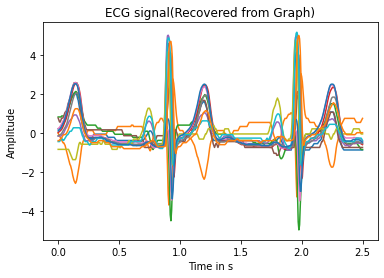

In [21]:
#%% Plot the graph of all 12 ECG signals of jth patient record number
j = 0
t = np.arange(0, (len(signals[j])/sampling_freq), (1/ sampling_freq))
plt.plot(t, signals[j])
plt.title("ECG signal(Recovered from Graph)")
plt.xlabel("Time in s")
plt.ylabel("Amplitude")
plt.ioff()
plt.savefig(new_path+'/'+'filtered_ecg_out.jpg')
plt.show()  

Performing 6 level wavelet decomposition using db9 wavelet

In [23]:
import pywt
from biorth_wavelet import custom_wavelet
dec_levels = 6         # decomposition levels
wave = custom_wavelet()

records = len(signals)
coeff = []

for patient in range(records):
    coeff += [pywt.wavedec(signals[patient], 
                           wavelet = wave, 
                           mode = 'zero', 
                           level = dec_levels, 
                           axis = 0)]

/home/ravisane/anaconda3/lib/python3.7/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


Plotting the subband coeff for jth record

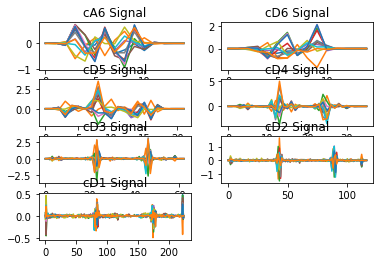

In [24]:
j = 0
c = coeff[j]
plt.figure(1)

for i in range(7):
    plt.subplot(4,2,i+1)
    t = np.arange(0, len(c[i]), 1)
    plt.plot(t, c[i])
    if i==0:
        plt.title("cA6 Signal")
    else:
        plt.title(f"cD{7-i} Signal")
        
plt.ioff()
plt.savefig(new_path+'/'+'filtered_ecg_out.jpg')
plt.show()

Calculate energy vectors for each record, we choose 4 subbands * 12 ecg leads => 48 long vector
Normalize this energy vector

Get eigen values of covariance matrix of 4 subband coefficient and find principal eigen values (we choose 6 values) => 24 long eigen vector

Concatenate the two vectors to get 72 length vector

In [11]:
from z_feature_vector import find_Z_feature
max_eig_values = 6     # top 6 eigen values to be taken of cov matrix of 4 subbands coeff
max_dec_levels = 4     # 4 subbands choosen cA6 cD6 cD5 cD4

# Get feature matrix by 48 energy values and 24 eigen values
Z = find_Z_feature(coeff, 
                   max_dec_levels=max_dec_levels, 
                   max_eig_values=max_eig_values,
                   num_leads=num_leads)

Apply 5 fold CV and clasifiers KNN, linear SVM, rbf SVM

In [12]:
#%% Apply 5 fold CV and clasifiers KNN, linear SVM, rbf SVM
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scores_knn = []
scores_linear = []
scores_rbf = []

neigh = KNeighborsClassifier(n_neighbors = 5)
svc_linear = SVC(kernel = 'linear', C=30.0)
#svc_rbf = SVC(kernel = 'rbf')

#svc_linear = make_pipeline(StandardScaler(), SVC(kernel = 'linear'))
svc_rbf = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', C=30.0))

cv = KFold(n_splits = 5, shuffle = True)

for train_index, test_index in cv.split(Z):
    X_train, X_test, y_train, y_test = Z[train_index], Z[test_index], label[train_index], label[test_index]
    
    # train classifiers    
    neigh.fit(X_train, y_train)
    scores_knn.append(neigh.score(X_test, y_test))
    
    svc_linear.fit(X_train, y_train)
    scores_linear.append(svc_linear.score(X_test, y_test))
    
    svc_rbf.fit(X_train, y_train)
    scores_rbf.append(svc_rbf.score(X_test, y_test))

# print avg scores  
print('KNN mean accuracy: ',np.mean(scores_knn))
print('Linear SVM mean accuracy: ',np.mean(scores_linear))
print('RBF SVM mean accuracy: ',np.mean(scores_rbf))

KNN mean accuracy:  0.5877551020408163
Linear SVM mean accuracy:  0.7612244897959183
RBF SVM mean accuracy:  0.7816326530612245


Print Classification report & Confusion Matrix

KNN Report & Confusion Matrix
              precision    recall  f1-score   support

          HC       0.51      0.86      0.64        42
          MI       0.79      0.39      0.52        56

    accuracy                           0.59        98
   macro avg       0.65      0.62      0.58        98
weighted avg       0.67      0.59      0.57        98



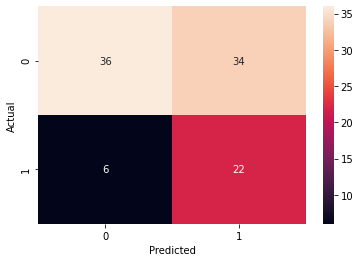

Linear SVM Report & Confusion Matrix
              precision    recall  f1-score   support

          HC       0.70      0.88      0.78        42
          MI       0.89      0.71      0.79        56

    accuracy                           0.79        98
   macro avg       0.79      0.80      0.79        98
weighted avg       0.81      0.79      0.79        98



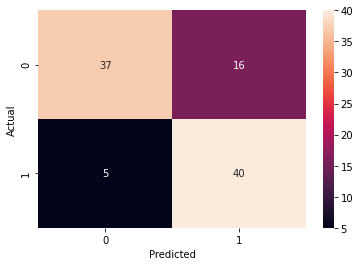

RBF SVM Report & Confusion Matrix
              precision    recall  f1-score   support

          HC       0.69      0.83      0.75        42
          MI       0.85      0.71      0.78        56

    accuracy                           0.77        98
   macro avg       0.77      0.77      0.76        98
weighted avg       0.78      0.77      0.77        98



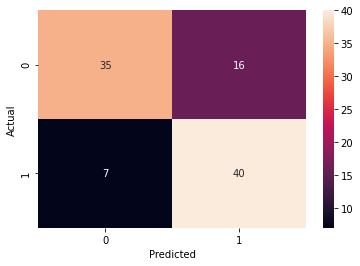

In [13]:
import seaborn as sn
from sklearn.metrics import classification_report

y_pred_KNN = neigh.predict(X_test)
y_pred_lsvc = svc_linear.predict(X_test)
y_pred_rsvc = svc_rbf.predict(X_test)

# function to create report and confusion matrix

def report_n_conf_mat(y_pred, y_test, file_name='Report.csv'):
    target_names = ['HC','MI']
    print(classification_report(y_test, y_pred, target_names=target_names))
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    report = pd.DataFrame(report).transpose()
    report.to_csv(file_name)
    
    data = {'y_Actual':    y_pred,
            'y_Predicted': y_test}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

    sn.heatmap(confusion_matrix, annot=True)
    plt.show()

print("KNN Report & Confusion Matrix")
report_n_conf_mat(y_pred_KNN, y_test, file_name=new_path+'/'+'KNN Classification Report.csv')


print("Linear SVM Report & Confusion Matrix")
report_n_conf_mat(y_pred_lsvc, y_test, file_name=new_path+'/'+'Linear SVM Classification Report.csv')

print("RBF SVM Report & Confusion Matrix")
report_n_conf_mat(y_pred_rsvc, y_test, file_name=new_path+'/'+'RBF SVM Classification Report.csv')


In [14]:
np.shape(data_recovered)

(490, 12, 441)

In [15]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data_recovered, label, test_size = 0.2) 

In [16]:
from DNN import call
import tensorflow as tf

default_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=10)

call(train_X, train_y, test_X, test_y, optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"], 
    epochs=60, batch_size=128, callbacks=default_callback, rb1=True, rb2=False, rb3=False)

Epoch 1/60
3/3 [==============================] - 2s 557ms/step - loss: 7.9413 - accuracy: 0.4792 - val_loss: 6.7560 - val_accuracy: 0.5570
Epoch 2/60
3/3 [==============================] - 0s 44ms/step - loss: 7.9413 - accuracy: 0.4792 - val_loss: 6.7560 - val_accuracy: 0.5570
Epoch 3/60
3/3 [==============================] - 0s 44ms/step - loss: 7.9413 - accuracy: 0.4792 - val_loss: 6.7560 - val_accuracy: 0.5570
Epoch 4/60
3/3 [==============================] - 0s 47ms/step - loss: 7.9413 - accuracy: 0.4792 - val_loss: 6.7560 - val_accuracy: 0.5570
Epoch 5/60
3/3 [==============================] - 0s 44ms/step - loss: 7.9413 - accuracy: 0.4792 - val_loss: 6.7560 - val_accuracy: 0.5570
Epoch 6/60
3/3 [==============================] - 0s 43ms/step - loss: 7.9413 - accuracy: 0.4792 - val_loss: 6.7560 - val_accuracy: 0.5570
Epoch 7/60
3/3 [==============================] - 0s 44ms/step - loss: 7.9413 - accuracy: 0.4792 - val_loss: 6.7560 - val_accuracy: 0.5570
Epoch 8/60
3/3 [==========

In [34]:
from tensorflow.keras import layers
model = tf.keras.Sequential([
    layers.Input((b,c)),
    layers.Conv1D(32, 11, 1, 'same', activation= 'relu'),
    layers.BatchNormalization(),
    layers.Conv1D(32, 5, 1, 'same', activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(32, 11, 1, 'same', activation= 'relu'),
    layers.BatchNormalization(),
    layers.Conv1D(32, 5, 1, 'same', activation= 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    
#     layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='softmax')
    ])
#%%
# model.summary()
# #%%
# from tensorflow.keras.losses import CategoricalCrossentropy
# model.compile(optimizer='adam', 
#               loss=CategoricalCrossentropy(from_logits=True), 
#               metrics=['accuracy'])
# history = model.fit(train_ds, validation_data=val_ds, epochs=3)



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(train_X.reshape(-1,b,c), train_y, validation_split=0.2, epochs=20, 
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=3))

#%%
test_loss, test_acc = model.evaluate(test_X.reshape(-1,b,c),  test_y, verbose=2)

print('\nTest accuracy:', test_acc)

Epoch 1/20
1/1 [==============================] - 0s 264ms/step - loss: 1.0986 - accuracy: 0.5312 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 42ms/step - loss: 1.0986 - accuracy: 0.5312 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 34ms/step - loss: 1.0986 - accuracy: 0.5312 - val_loss: 1.0986 - val_accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 35ms/step - loss: 1.0986 - accuracy: 0.5312 - val_loss: 1.0986 - val_accuracy: 0.5000
1/1 - 0s - loss: 1.0986 - accuracy: 0.4000

Test accuracy: 0.4000000059604645
